# Mohammad Amin Kiani - 4043644008
## Numb Groups problem
##### T2.HW1 - EA - Dr.Karshenas
##### ui.ac.ir

## Imports & Load...

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import random
import pandas as pd

## EA Funcs

In [2]:
def get_primes_up_to(n):
    """برمی‌گرداند لیست اعداد اول بین 1 تا n (شامل n)."""
    if n < 2:
        return []
    sieve = [True] * (n + 1)
    sieve[0] = sieve[1] = False
    for p in range(2, int(n**0.5) + 1):
        if sieve[p]:
            for m in range(p*p, n+1, p):
                sieve[m] = False
    return [i for i in range(2, n+1) if sieve[i]]

In [3]:

def is_valid_solution(x, n, k, primes):
    """
    قیدهای سخت:
    1) هیچ دو عدد متوالی (i و i+1) در یک گروه نباشند.
    2) هیچ دو عدد اول در یک گروه نباشند.
    x: آرایه طول n با مقادیر 1..k
    """
    # قید 1: دو عدد متوالی
    for i in range(n - 1):
        if x[i] == x[i+1]:
            return False

    # قید 2: اعداد اول
    primes_set = set(primes)
    group_prime_count = {g: 0 for g in range(1, k+1)}
    for idx in range(n):
        number = idx + 1  # اعداد 1..n
        if number in primes_set:
            g = int(x[idx])
            group_prime_count[g] += 1
            if group_prime_count[g] > 1:
                return False

    return True

In [4]:
def compute_group_sums(x, k):
    """
    x: آرایه‌ی گروه‌ها (1..k) برای اعداد 1..n
    خروجی:  group -> sum(numbers)
    """
    n = len(x)
    sums = {g: 0 for g in range(1, k+1)}
    for idx in range(n):
        number = idx + 1
        g = int(x[idx])
        sums[g] += number
    return sums

def fitness_grouping(x, n, k, primes):
    """
    تابع برازندگی:
    - اگر قیدهای سخت نقض شوند = 0
    - در غیر این صورت:
        group_sums را حساب می‌کنیم
        imbalance = max(sum) - min(sum)
        fitness = 1 / (1 + imbalance)
      هرچه تعادل گروه‌ها بهتر (imbalance کوچک‌تر) = fitness نزدیک‌تر به ۱
    """
    if not is_valid_solution(x, n, k, primes):
        return 0.0

    sums = compute_group_sums(x, k)
    vals = list(sums.values())
    imbalance = max(vals) - min(vals)
    return 1.0 / (1.0 + float(imbalance))

def evaluate_population(pop, n, k, primes):
    """برازندگی کل جمعیت."""
    return np.array([fitness_grouping(ind, n, k, primes) for ind in pop],
                    dtype=float)

## Selection

In [26]:
def roulette_wheel_selection(pop, fitnesses, num_selected):
    """
    انتخاب متناسب با برازندگی (چرخ‌گردونه).
    اگر مجموع برازندگی‌ها صفر باشد = انتخاب تصادفی یکنواخت.
    """
    pop_size = len(pop)
    total_fit = float(np.sum(fitnesses))
    if total_fit <= 0:
      # همه صفر : انتخاب تصادفی یکنواخت
        idx = np.random.randint(0, pop_size, size=num_selected)
        return pop[idx].copy()

    # احتمال نسبی هر فرد
    probs = fitnesses / total_fit
    cum_probs = np.cumsum(probs)
    selected = []
    for _ in range(num_selected):
        r = np.random.rand()
        idx = np.searchsorted(cum_probs, r)
        selected.append(pop[idx].copy())
    return np.array(selected)



# برای بخش خ – رقابت دودویی با جایگزینی
def tournament_selection(pop, fitnesses, num_selected, tournament_size=2):
    """
    انتخاب رقابت دودویی (binary tournament).
    در صورت نیاز برای سوال اختیاری خ.
    """
    pop_size = len(pop)
    selected = []
    for _ in range(num_selected):
        # sample indices بدون ترتیب
        competitors = np.random.choice(pop_size, size=tournament_size, replace=False)
        best_idx = competitors[0]
        for idx in competitors[1:]:
            if fitnesses[idx] > fitnesses[best_idx]:
                best_idx = idx
        selected.append(pop[best_idx].copy())
    return np.array(selected)

## CrossOver

In [6]:
def two_point_crossover(parent_pool, Pc):
    """
    بازترکیب دو نقطه‌ای برای نمایش عددی.
    parent_pool: ماتریس (pop_size, n)
    Pc: احتمال اعمال بازترکیب برای هر جفت والد.
    """
    pop_size, n = parent_pool.shape
    indices = np.arange(pop_size)
    np.random.shuffle(indices)
    shuffled = parent_pool[indices]

    children = []
    for i in range(0, pop_size, 2):
        p1 = shuffled[i]
        p2 = shuffled[(i + 1) % pop_size]
        if np.random.rand() < Pc:
            c1 = p1.copy()
            c2 = p2.copy()
            cpt1 = np.random.randint(0, n-1)
            cpt2 = np.random.randint(cpt1 + 1, n)
            # تعویض بازه‌ی بین دو نقطه
            c1[cpt1:cpt2], c2[cpt1:cpt2] = p2[cpt1:cpt2].copy(), p1[cpt1:cpt2].copy()
        else:
            c1 = p1.copy()
            c2 = p2.copy()
        children.append(c1)
        children.append(c2)

    return np.array(children[:pop_size])

## Mutation

In [7]:

def creeping_mutation(offspring, Pm, k):
    """
    جهش خزیدن:
    برای هر ژن با احتمال Pm:
      - با احتمال 0.5 اگر >1 باشد یک واحد کم می‌شود
      - با احتمال 0.5 اگر <k باشد یک واحد زیاد می‌شود
    """
    pop_size, n = offspring.shape
    for i in range(pop_size):
        for j in range(n):
            if np.random.rand() < Pm:
                if np.random.rand() < 0.5:
                    if offspring[i, j] > 1:
                        offspring[i, j] -= 1
                else:
                    if offspring[i, j] < k:
                        offspring[i, j] += 1
    return offspring

## Run :

In [24]:
def run_ea_grouping(n,
                    k,
                    pop_size=100,
                    max_generations=400,
                    Pc=0.8,
                    Pm=0.2,
                    selection_type="roulette",   # "roulette" یا "tournament"
                    tournament_size=2,
                    random_seed=None):
    """
    اجرای کامل الگوریتم تکاملی برای مسئله‌ی گروه‌بندی اعداد.
    - نمایش عددی (هر ژن ∈ {1..k})
    - انتخاب: متنـاسب با برازندگی یا رقابت دودویی
    - بازترکیب دو نقطه‌ای
    - جهش خزیدن
    - جایگزینی elitist از pop + offspring
    خروجی: دیکشنری شامل هیستوری برازندگی‌ها و جمعیت نهایی.
    """
    if random_seed is not None:
        np.random.seed(random_seed)
        random.seed(random_seed)

    primes = get_primes_up_to(n)

    # جمعیت اولیه: هر ژن عددی بین 1..k
    pop = np.random.randint(1, k+1, size=(pop_size, n))

    best_history = []
    worst_history = []
    mean_history = []

    for gen in range(max_generations):
        fitnesses = evaluate_population(pop, n, k, primes)

        best_history.append(float(np.max(fitnesses)))
        worst_history.append(float(np.min(fitnesses)))
        mean_history.append(float(np.mean(fitnesses)))

        # --- انتخاب والد
        if selection_type == "roulette":
            parents = roulette_wheel_selection(pop, fitnesses, pop_size)
        elif selection_type == "tournament":
            parents = tournament_selection(pop, fitnesses, pop_size,
                                           tournament_size=tournament_size)
        else:
            raise ValueError("selection_type باید 'roulette' یا 'tournament' باشد")

        # --- بازترکیب دو نقطه‌ای
        offspring = two_point_crossover(parents, Pc)

        # --- جهش خزیدن
        offspring = creeping_mutation(offspring, Pm, k)

        # --- ارزیابی فرزندان
        off_fits = evaluate_population(offspring, n, k, primes)

        # --- جایگزینی elitist از pop + offspring
        combined_pop = np.vstack([pop, offspring])
        combined_fit = np.concatenate([fitnesses, off_fits])

        order = np.argsort(-combined_fit)  # برازندگی بزرگتر بهتر است
        pop = combined_pop[order[:pop_size]]

    final_fitnesses = evaluate_population(pop, n, k, primes)

    return {
        "best_history": np.array(best_history),
        "worst_history": np.array(worst_history),
        "mean_history": np.array(mean_history),
        "final_population": pop,
        "final_fitnesses": final_fitnesses,
        "primes": primes,
    }

## Plots :

In [9]:
def plot_evolution(best_hist, worst_hist, mean_hist, title="Evolution – Grouping"):
    gens = np.arange(len(best_hist))
    plt.figure()
    plt.plot(gens, best_hist, label="Best fitness")
    plt.plot(gens, mean_hist, label="Mean fitness")
    plt.plot(gens, worst_hist, label="Worst fitness")
    plt.xlabel("Generation")
    plt.ylabel("Fitness")
    plt.title(title)
    plt.legend()
    plt.grid(True)
    plt.show()

def multi_run_mean_std(n, k,
                       pop_size=100,
                       max_generations=400,
                       Pc=0.8,
                       Pm=0.2,
                       runs=6,
                       selection_type="roulette"):
    """
    برای یک تنظیم مشخص، الگوریتم را runs بار اجرا می‌کند
    و میانگین و انحراف معیار mean_fitness در هر نسل را برمی‌گرداند.
    """
    all_mean_hist = []
    for r in range(runs):
        res = run_ea_grouping(
            n=n, k=k,
            pop_size=pop_size,
            max_generations=max_generations,
            Pc=Pc, Pm=Pm,
            selection_type=selection_type,
            random_seed=r
        )
        all_mean_hist.append(res["mean_history"])
    all_mean_hist = np.array(all_mean_hist)
    mean_over_runs = np.mean(all_mean_hist, axis=0)
    std_over_runs  = np.std(all_mean_hist, axis=0)
    return mean_over_runs, std_over_runs

def plot_mean_std(mean_over_runs, std_over_runs, title="Mean & Std of mean fitness"):
    gens = np.arange(len(mean_over_runs))
    plt.figure()
    plt.plot(gens, mean_over_runs, label="Mean of population mean")
    plt.plot(gens, mean_over_runs + std_over_runs, linestyle="--", label="Mean + std")
    plt.plot(gens, mean_over_runs - std_over_runs, linestyle="--", label="Mean - std")
    plt.xlabel("Generation")
    plt.ylabel("Mean fitness")
    plt.title(title)
    plt.legend()
    plt.grid(True)
    plt.show()

def get_best_solution_info(result, n, k):
    """
    از خروجی run_ea_grouping بهترین فرد نهایی را استخراج می‌کند.
    خروجی: دیکشنری شامل assignment، fitness، group_sums و ...
    """
    primes = result["primes"]
    final_pop = result["final_population"]
    final_fit = result["final_fitnesses"]
    idx_best = int(np.argmax(final_fit))
    x_best = final_pop[idx_best]
    fit_best = float(final_fit[idx_best])
    sums = compute_group_sums(x_best, k)
    return {
        "assignment": x_best,
        "fitness": fit_best,
        "group_sums": sums,
        "primes": primes,
    }

def assignment_to_str(assignment, group=10):
    """
    برای زیباتر شدن نمایش کروموزوم (برای گزارش).
    """
    arr = list(map(int, assignment))
    chunks = []
    for i in range(0, len(arr), group):
        chunk = arr[i:i+group]
        chunks.append(" ".join(str(x) for x in chunk))
    return " | ".join(chunks)

def group_sums_to_str(group_sums):
    return "; ".join(f"g{g}: {s}" for g, s in group_sums.items())


In [10]:
# اصلاحیه TA

K_MAP = {
    10: 5,
    20: 8,
    40: 12,
    60: 17,
}


## QA ?

### 1-
یک اجرای EA و نمودار تکامل (n=10, k=5)

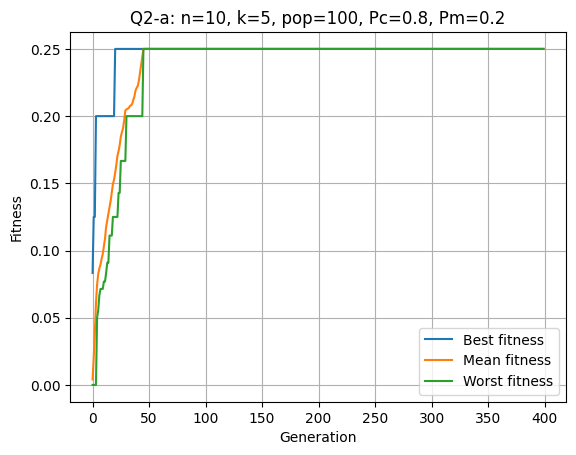

In [15]:
n = 10
k = K_MAP[n]

res_a = run_ea_grouping(
    n=n, k=k,
    pop_size=100,
    max_generations=400,
    Pc=0.8,
    Pm=0.2,
    selection_type="roulette",
    random_seed=0
)

plot_evolution(
    res_a["best_history"],
    res_a["worst_history"],
    res_a["mean_history"],
    title="Q2-a: n=10, k=5, pop=100, Pc=0.8, Pm=0.2"
)


### 2-
تعداد ۶ اجرای مختلف و نمودار میانگین و انحراف معیار

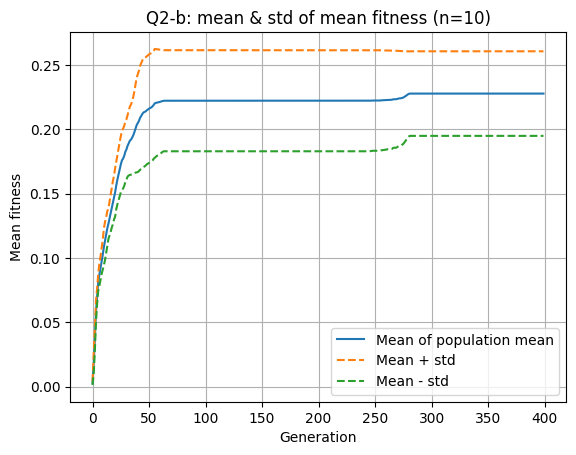

In [16]:
mean_over_runs, std_over_runs = multi_run_mean_std(
    n=10,
    k=K_MAP[10],
    pop_size=100,
    max_generations=400,
    Pc=0.8,
    Pm=0.2,
    runs=6,
    selection_type="roulette"
)

plot_mean_std(
    mean_over_runs,
    std_over_runs,
    title="Q2-b: mean & std of mean fitness (n=10)"
)


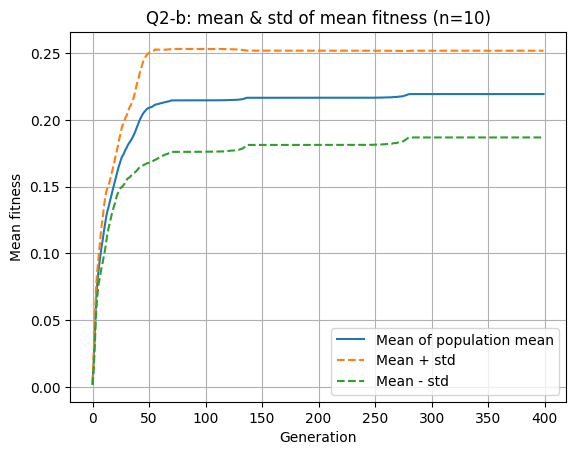

In [17]:
mean_over_runs, std_over_runs = multi_run_mean_std(
    n=10,
    k=K_MAP[10],
    pop_size=100,
    max_generations=400,
    Pc=0.8,
    Pm=0.2,
    runs=12,
    selection_type="roulette"
)

plot_mean_std(
    mean_over_runs,
    std_over_runs,
    title="Q2-b: mean & std of mean fitness (n=10)"
)


### 3-
اثر اندازه‌ی مسئله (n ∈ {10,20,40,60})

معیار عملکرد = میانگین برازندگی جمعیت نهایی در هر اجرا

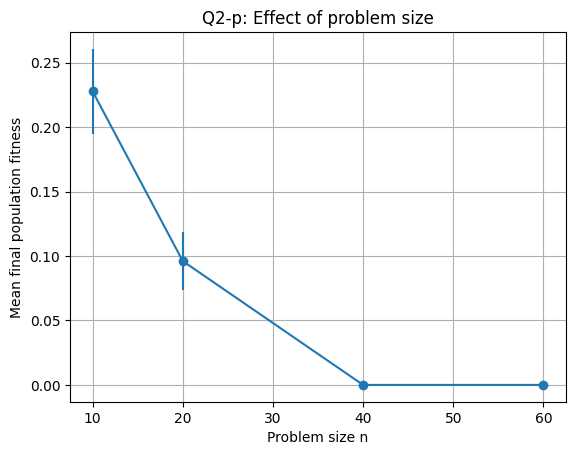

In [12]:
problem_sizes = [10, 20, 40, 60]
num_runs = 6

mean_perf = []
std_perf = []

for n in problem_sizes:
    k = K_MAP[n]
    run_means = []
    for r in range(num_runs):
        res = run_ea_grouping(
            n=n, k=k,
            pop_size=100,
            max_generations=400,
            Pc=0.8,
            Pm=0.2,
            selection_type="roulette",
            random_seed=r
        )
        final_mean = float(np.mean(res["final_fitnesses"]))
        run_means.append(final_mean)
    mean_perf.append(np.mean(run_means))
    std_perf.append(np.std(run_means))

plt.figure()
plt.errorbar(problem_sizes, mean_perf, yerr=std_perf, fmt='-o')
plt.xlabel("Problem size n")
plt.ylabel("Mean final population fitness")
plt.title("Q2-p: Effect of problem size")
plt.grid(True)
plt.show()


In [20]:
n = 40
k = K_MAP[n]
res = run_ea_grouping(
    n=n, k=k,
    pop_size=100,
    max_generations=400,
    Pc=0.8,
    Pm=0.2,
    selection_type="roulette",
    random_seed=0
)

print("best fitness:", res["final_fitnesses"].max())
print("mean fitness:", res["final_fitnesses"].mean())


best fitness: 0.0
mean fitness: 0.0


### 4-
اثر تعداد نسل‌ها {50,100,200,300} برای هر n


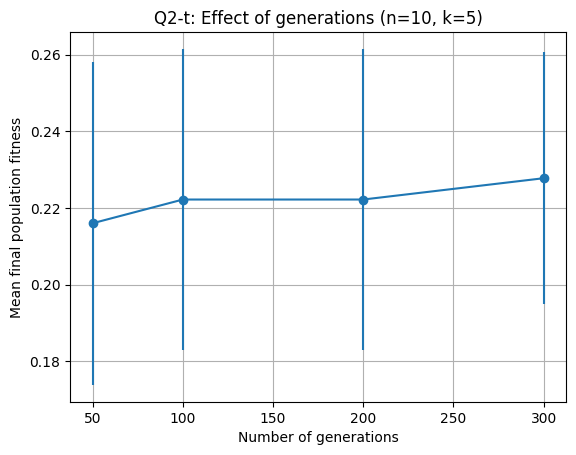

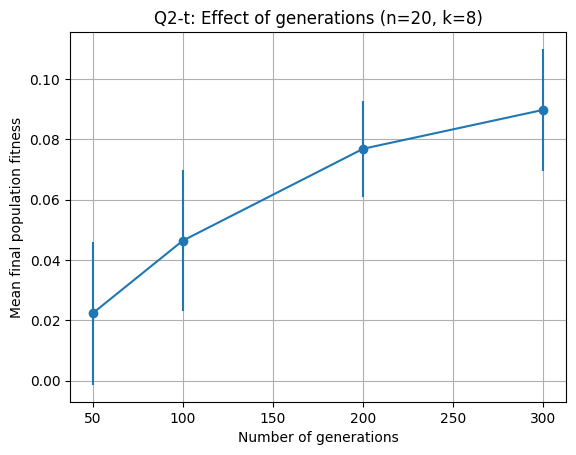

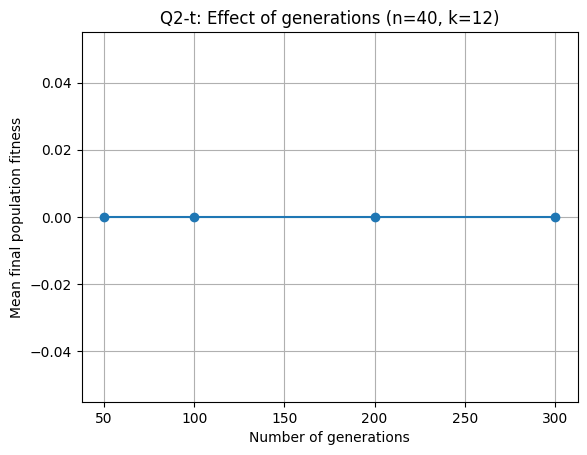

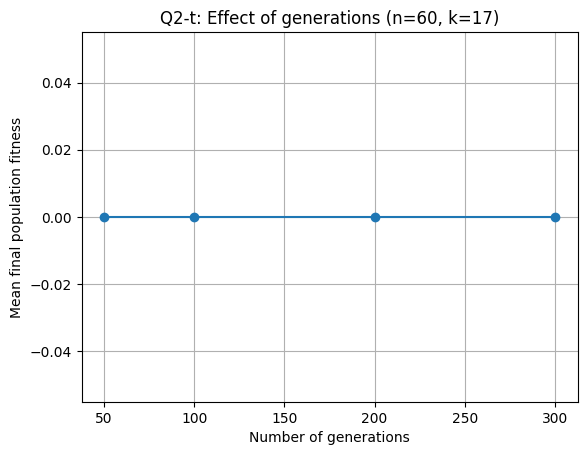

In [19]:
gen_values = [50, 100, 200, 300]
num_runs = 6

for n in problem_sizes:  # [10, 20, 40, 60]
    k = K_MAP[n]
    mean_perf = []
    std_perf = []
    for gens in gen_values:
        run_means = []
        for r in range(num_runs):
            res = run_ea_grouping(
                n=n, k=k,
                pop_size=100,
                max_generations=gens,
                Pc=0.8,
                Pm=0.2,
                selection_type="roulette",
                random_seed=r
            )
            final_mean = float(np.mean(res["final_fitnesses"]))
            run_means.append(final_mean)
        mean_perf.append(np.mean(run_means))
        std_perf.append(np.std(run_means))

    plt.figure()
    plt.errorbar(gen_values, mean_perf, yerr=std_perf, fmt='-o')
    plt.xlabel("Number of generations")
    plt.ylabel("Mean final population fitness")
    plt.title(f"Q2-t: Effect of generations (n={n}, k={k})")
    plt.grid(True)
    plt.show()


### 5-
تأثیر اندازه جمعیت (popSize ∈ {50, 100, 200, 300})

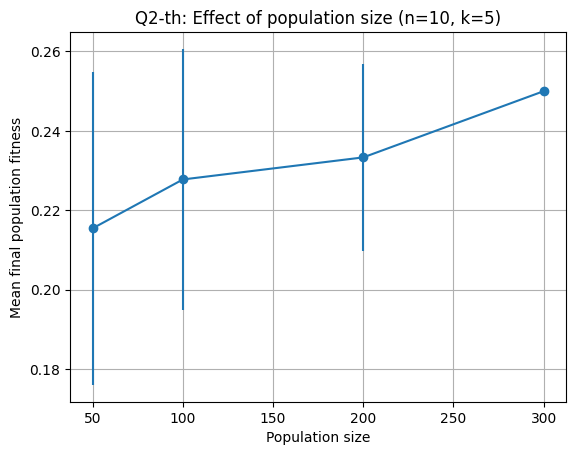

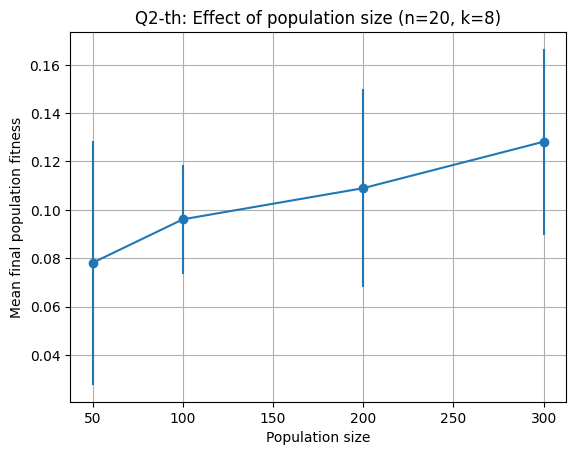

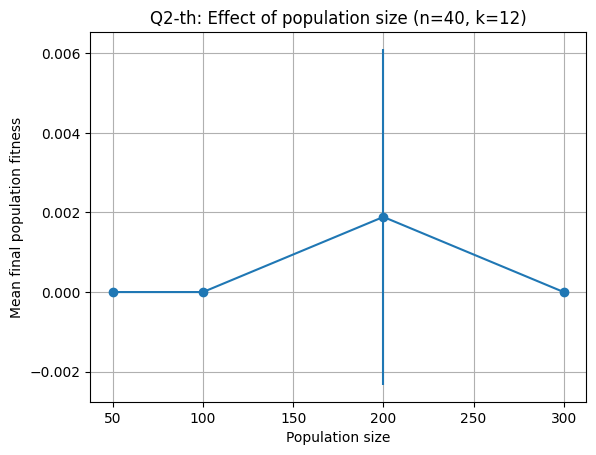

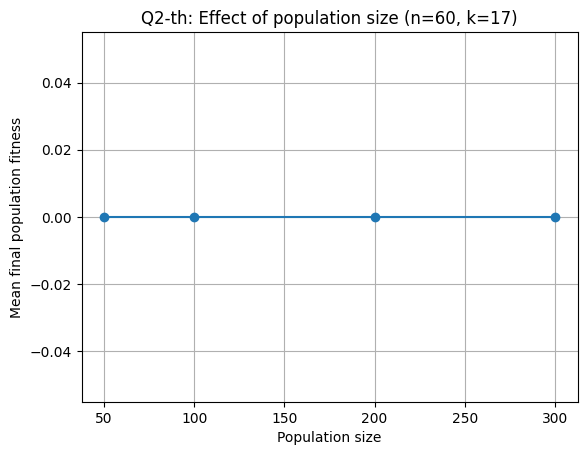

In [21]:
pop_sizes = [50, 100, 200, 300]
num_runs = 6

for n in problem_sizes:
    k = K_MAP[n]
    mean_perf = []
    std_perf = []
    for pop_size in pop_sizes:
        run_means = []
        for r in range(num_runs):
            res = run_ea_grouping(
                n=n, k=k,
                pop_size=pop_size,
                max_generations=400,
                Pc=0.8,
                Pm=0.2,
                selection_type="roulette",
                random_seed=r
            )
            final_mean = float(np.mean(res["final_fitnesses"]))
            run_means.append(final_mean)
        mean_perf.append(np.mean(run_means))
        std_perf.append(np.std(run_means))

    plt.figure()
    plt.errorbar(pop_sizes, mean_perf, yerr=std_perf, fmt='-o')
    plt.xlabel("Population size")
    plt.ylabel("Mean final population fitness")
    plt.title(f"Q2-th: Effect of population size (n={n}, k={k})")
    plt.grid(True)
    plt.show()


### 6-
تأثیر احتمال بازترکیب

Pc ∈ {0.6,0.7,0.9,1}


In [ ]:
problem_sizes = [10, 20, 40, 60]

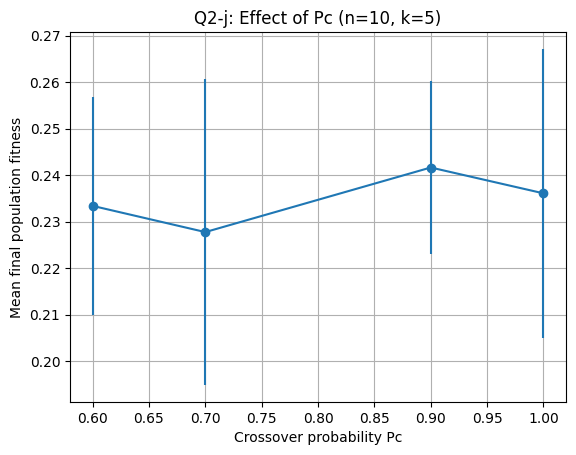

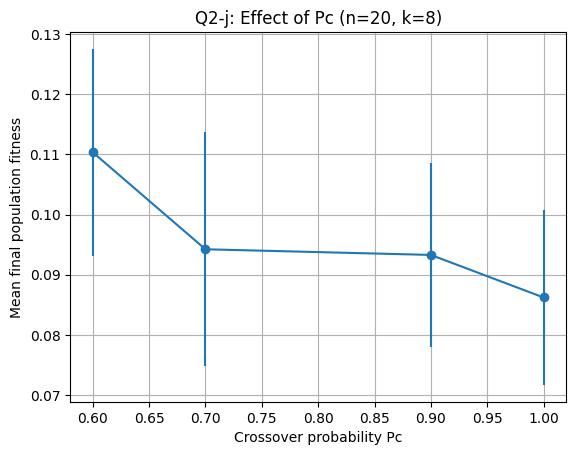

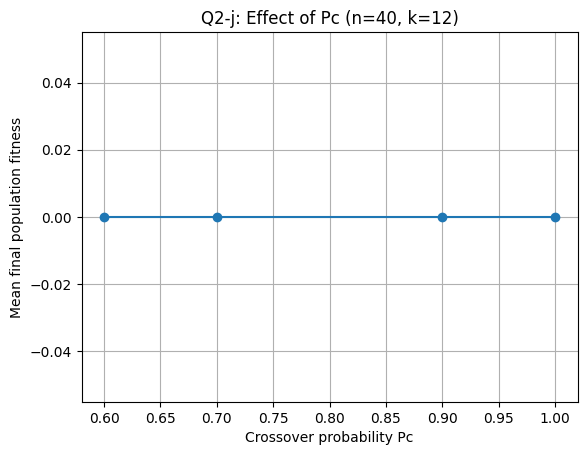

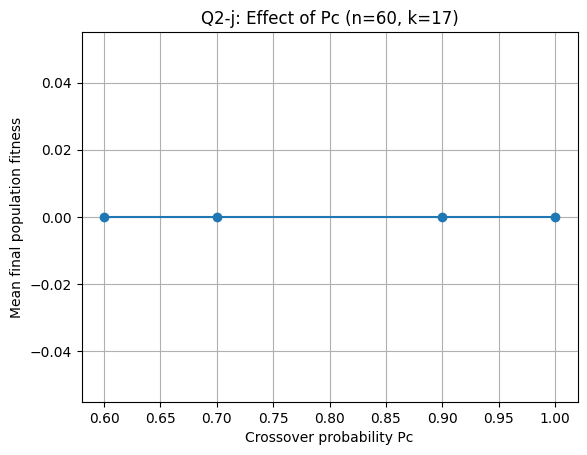

In [13]:
Pc_values = [0.6, 0.7, 0.9, 1.0]
num_runs = 6

for n in problem_sizes:
    k = K_MAP[n]
    mean_perf = []
    std_perf = []
    for Pc in Pc_values:
        run_means = []
        for r in range(num_runs):
            res = run_ea_grouping(
                n=n, k=k,
                pop_size=100,
                max_generations=400,
                Pc=Pc,
                Pm=0.2,
                selection_type="roulette",
                random_seed=r
            )
            final_mean = float(np.mean(res["final_fitnesses"]))
            run_means.append(final_mean)
        mean_perf.append(np.mean(run_means))
        std_perf.append(np.std(run_means))

    plt.figure()
    plt.errorbar(Pc_values, mean_perf, yerr=std_perf, fmt='-o')
    plt.xlabel("Crossover probability Pc")
    plt.ylabel("Mean final population fitness")
    plt.title(f"Q2-j: Effect of Pc (n={n}, k={k})")
    plt.grid(True)
    plt.show()


### 7-
تأثیر احتمال جهش

Pm ∈ {0.05,0.1,0.3,0.5}

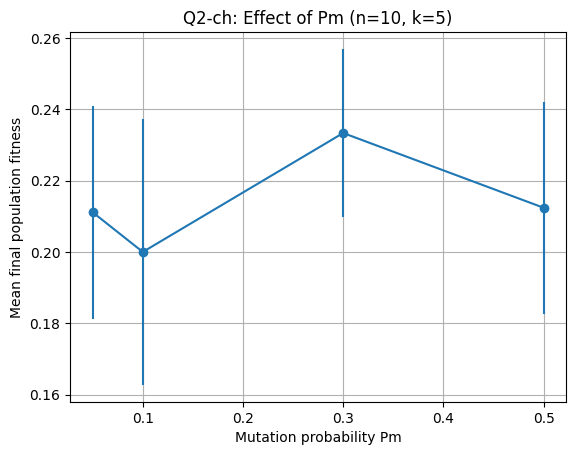

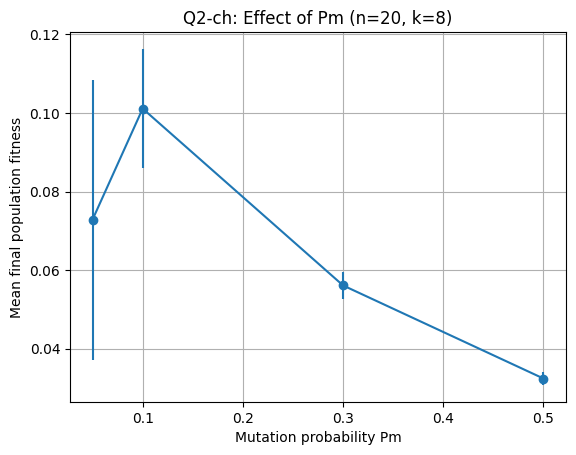

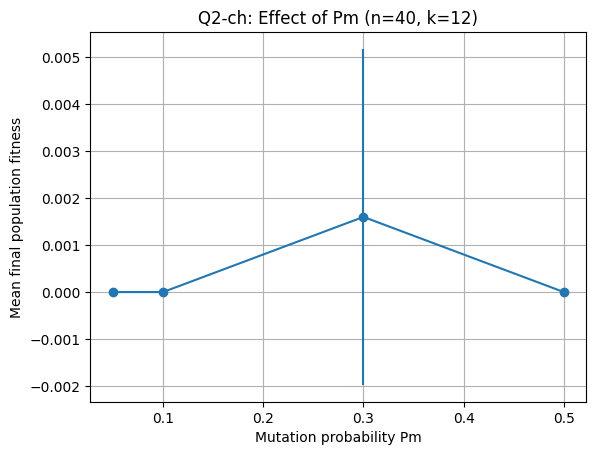

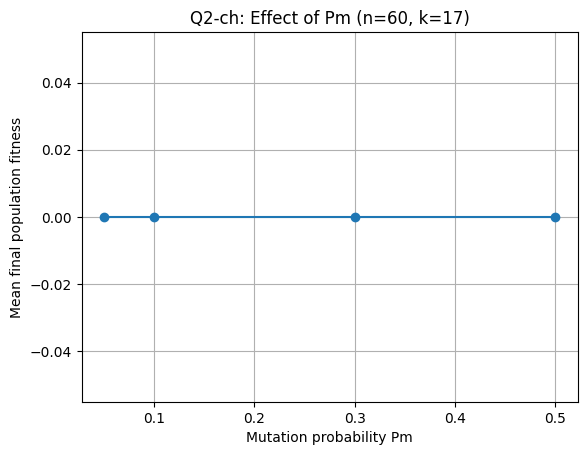

In [14]:
Pm_values = [0.05, 0.10, 0.30, 0.50]
num_runs = 6

for n in problem_sizes:
    k = K_MAP[n]
    mean_perf = []
    std_perf = []
    for Pm in Pm_values:
        run_means = []
        for r in range(num_runs):
            res = run_ea_grouping(
                n=n, k=k,
                pop_size=100,
                max_generations=400,
                Pc=0.8,
                Pm=Pm,
                selection_type="roulette",
                random_seed=r
            )
            final_mean = float(np.mean(res["final_fitnesses"]))
            run_means.append(final_mean)
        mean_perf.append(np.mean(run_means))
        std_perf.append(np.std(run_means))

    plt.figure()
    plt.errorbar(Pm_values, mean_perf, yerr=std_perf, fmt='-o')
    plt.xlabel("Mutation probability Pm")
    plt.ylabel("Mean final population fitness")
    plt.title(f"Q2-ch: Effect of Pm (n={n}, k={k})")
    plt.grid(True)
    plt.show()


### 8-
بهترین راه‌حل برای تمام تنظیم‌ها

In [15]:
configs = []

for n in problem_sizes:
    k = K_MAP[n]
    configs.append({
        "label": "p_problem_size",
        "n": n,
        "k": k,
        "pop_size": 100,
        "max_generations": 400,
        "Pc": 0.8,
        "Pm": 0.2,
    })


RUNS = 6
best_rows = []

for cfg in configs:
    label = cfg["label"]
    n = cfg["n"]
    k = cfg["k"]
    pop_size = cfg["pop_size"]
    max_gen = cfg["max_generations"]
    Pc = cfg["Pc"]
    Pm = cfg["Pm"]

    best_overall = None

    for r in range(RUNS):
        res = run_ea_grouping(
            n=n, k=k,
            pop_size=pop_size,
            max_generations=max_gen,
            Pc=Pc, Pm=Pm,
            selection_type="roulette",
            random_seed=r
        )
        info = get_best_solution_info(res, n, k)

        if (best_overall is None) or (info["fitness"] > best_overall["fitness"]):
            best_overall = info
            best_overall["run"] = r

    assign_str = assignment_to_str(best_overall["assignment"], group=10)
    sums_str   = group_sums_to_str(best_overall["group_sums"])

    best_rows.append({
        "label": label,
        "n": n,
        "k": k,
        "pop_size": pop_size,
        "max_generations": max_gen,
        "Pc": Pc,
        "Pm": Pm,
        "best_run": best_overall["run"],
        "best_fitness": best_overall["fitness"],
        "assignment": assign_str,
        "group_sums": sums_str,
    })

best_df_grouping = pd.DataFrame(best_rows)
best_df_grouping.head()


,label,n,k,pop_size,max_generations,Pc,Pm,best_run,best_fitness,assignment,group_sums
0,p_problem_size,10,5,100,400,0.8,0.2,0,0.250000,1 4 1 5 3 1 5 3 4 2,g1: 10; g2: 10; g3: 13; g4: 11; g5: 11
1,p_problem_size,20,8,100,400,0.8,0.2,1,0.142857,6 5 7 1 3 5 4 7 4 8 | 6 4 2 6 5 2 8 7 1 3,g1: 23; g2: 29; g3: 25; g4: 28; g5: 23; g6: 26...
2,p_problem_size,40,12,100,400,0.8,0.2,0,0.000000,6 1 4 12 4 8 10 4 6 3 | 5 8 7 9 9 11 2 7 8 8 |...,g1: 63; g2: 75; g3: 43; g4: 222; g5: 38; g6: 6...
3,p_problem_size,60,17,100,400,0.8,0.2,0,0.000000,13 16 1 4 4 8 10 5 7 13 | 2 7 8 15 6 14 9 10 1...,g1: 207; g2: 130; g3: 34; g4: 169; g5: 146; g6...


In [16]:
best_df_grouping.to_csv("EA_grouping_best_solutions.csv", index=False)


برای هر تنظیم (label, n, k, پارامترها)، بهترین کروموزوم، برازندگی و مجموع هر گروه را دارد.

In [30]:
import pandas as pd
import numpy as np


configs = []
RUNS = 6
# --- Q2-a/b: پایه (n=10, k=5, pop=100, gens=400, Pc=0.8, Pm=0.2) ---
configs.append({
    "label": "a_base_n10",
    "description": "Q2-a/b base: n=10, k=5, pop=100, gens=400, Pc=0.8, Pm=0.2",
    "n": 10,
    "k": K_MAP[10],
    "pop_size": 100,
    "max_generations": 400,
    "Pc": 0.8,
    "Pm": 0.2,
})

# --- Q2-p: اثر اندازه‌ی مسئله (n ∈ {10,20,40,60}) ---
for n in [10, 20, 40, 60]:
    configs.append({
        "label": f"p_problem_size_n{n}",
        "description": f"Q2-p: effect of problem size n={n}",
        "n": n,
        "k": K_MAP[n],
        "pop_size": 100,
        "max_generations": 400,
        "Pc": 0.8,
        "Pm": 0.2,
    })

# --- Q2-t: اثر تعداد نسل‌ها {50,100,200,300} برای هر n ---
for n in [10, 20, 40, 60]:
    for gens in [50, 100, 200, 300]:
        configs.append({
            "label": f"t_generations_n{n}_g{gens}",
            "description": f"Q2-t: effect of generations n={n}, gens={gens}",
            "n": n,
            "k": K_MAP[n],
            "pop_size": 100,
            "max_generations": gens,
            "Pc": 0.8,
            "Pm": 0.2,
        })

# --- Q2-th (ث): اثر اندازه‌ی جمعیت {50,100,200,300} برای هر n ---
for n in [10, 20, 40, 60]:
    for pop_size in [50, 100, 200, 300]:
        configs.append({
            "label": f"th_pop_n{n}_p{pop_size}",
            "description": f"Q2-th: effect of population size n={n}, pop={pop_size}",
            "n": n,
            "k": K_MAP[n],
            "pop_size": pop_size,
            "max_generations": 400,
            "Pc": 0.8,
            "Pm": 0.2,
        })

# --- Q2-j (ج): اثر احتمال بازترکیب Pc ∈ {0.6,0.7,0.9,1} برای هر n ---
for n in [10, 20, 40, 60]:
    for Pc in [0.6, 0.7, 0.9, 1.0]:
        configs.append({
            "label": f"j_Pc_n{n}_Pc{Pc}",
            "description": f"Q2-j: effect of Pc n={n}, Pc={Pc}",
            "n": n,
            "k": K_MAP[n],
            "pop_size": 100,
            "max_generations": 400,
            "Pc": Pc,
            "Pm": 0.2,
        })

# --- Q2-ch (چ): اثر احتمال جهش Pm ∈ {0.05,0.1,0.3,0.5} برای هر n ---
for n in [10, 20, 40, 60]:
    for Pm in [0.05, 0.10, 0.30, 0.50]:
        configs.append({
            "label": f"ch_Pm_n{n}_Pm{Pm}",
            "description": f"Q2-ch: effect of Pm n={n}, Pm={Pm}",
            "n": n,
            "k": K_MAP[n],
            "pop_size": 100,
            "max_generations": 400,
            "Pc": 0.8,
            "Pm": Pm,
        })

print("Total number of configs:", len(configs))


Total number of configs: 69


In [31]:
best_rows = []

for idx, cfg in enumerate(configs, start=1):
    label = cfg["label"]
    desc  = cfg["description"]
    n     = cfg["n"]
    k     = cfg["k"]
    pop_size = cfg["pop_size"]
    max_gen  = cfg["max_generations"]
    Pc    = cfg["Pc"]
    Pm    = cfg["Pm"]

    print(f"[{idx}/{len(configs)}] Running config: {label}  ({desc})")

    best_overall = None

    for r in range(RUNS):
        res = run_ea_grouping(
            n=n, k=k,
            pop_size=pop_size,
            max_generations=max_gen,
            Pc=Pc, Pm=Pm,
            selection_type="roulette",     # برای همه‌ی سوال‌های اصلی انتخاب چرخ‌گردونه
            random_seed=r
        )
        info = get_best_solution_info(res, n, k)

        # انتخاب بهترین بین اجراها بر اساس fitness
        if (best_overall is None) or (info["fitness"] > best_overall["fitness"]):
            best_overall = info
            best_overall["run"] = r

    # تبدیل به رشته‌های خوانا برای گزارش
    assign_str = assignment_to_str(best_overall["assignment"], group=10)
    sums_str   = group_sums_to_str(best_overall["group_sums"])

    best_rows.append({
        "label": label,
        "description": desc,
        "selection": "roulette",
        "n": n,
        "k": k,
        "pop_size": pop_size,
        "max_generations": max_gen,
        "Pc": Pc,
        "Pm": Pm,
        "best_run_index": best_overall["run"],
        "best_fitness": best_overall["fitness"],
        "assignment": assign_str,
        "group_sums": sums_str,
    })

best_df_grouping = pd.DataFrame(best_rows)
best_df_grouping.head()


[1/69] Running config: a_base_n10  (Q2-a/b base: n=10, k=5, pop=100, gens=400, Pc=0.8, Pm=0.2)
[2/69] Running config: p_problem_size_n10  (Q2-p: effect of problem size n=10)
[3/69] Running config: p_problem_size_n20  (Q2-p: effect of problem size n=20)
[4/69] Running config: p_problem_size_n40  (Q2-p: effect of problem size n=40)
[5/69] Running config: p_problem_size_n60  (Q2-p: effect of problem size n=60)
[6/69] Running config: t_generations_n10_g50  (Q2-t: effect of generations n=10, gens=50)
[7/69] Running config: t_generations_n10_g100  (Q2-t: effect of generations n=10, gens=100)
[8/69] Running config: t_generations_n10_g200  (Q2-t: effect of generations n=10, gens=200)
[9/69] Running config: t_generations_n10_g300  (Q2-t: effect of generations n=10, gens=300)
[10/69] Running config: t_generations_n20_g50  (Q2-t: effect of generations n=20, gens=50)
[11/69] Running config: t_generations_n20_g100  (Q2-t: effect of generations n=20, gens=100)
[12/69] Running config: t_generations_n

,label,description,selection,n,k,pop_size,max_generations,Pc,Pm,best_run_index,best_fitness,assignment,group_sums
0,a_base_n10,"Q2-a/b base: n=10, k=5, pop=100, gens=400, Pc=...",roulette,10,5,100,400,0.8,0.2,0,0.250000,1 4 1 5 3 1 5 3 4 2,g1: 10; g2: 10; g3: 13; g4: 11; g5: 11
1,p_problem_size_n10,Q2-p: effect of problem size n=10,roulette,10,5,100,400,0.8,0.2,0,0.250000,1 4 1 5 3 1 5 3 4 2,g1: 10; g2: 10; g3: 13; g4: 11; g5: 11
2,p_problem_size_n20,Q2-p: effect of problem size n=20,roulette,20,8,100,400,0.8,0.2,1,0.142857,6 5 7 1 3 5 4 7 4 8 | 6 4 2 6 5 2 8 7 1 3,g1: 23; g2: 29; g3: 25; g4: 28; g5: 23; g6: 26...
3,p_problem_size_n40,Q2-p: effect of problem size n=40,roulette,40,12,100,400,0.8,0.2,0,0.000000,6 1 4 12 4 8 10 4 6 3 | 5 8 7 9 9 11 2 7 8 8 |...,g1: 63; g2: 75; g3: 43; g4: 222; g5: 38; g6: 6...
4,p_problem_size_n60,Q2-p: effect of problem size n=60,roulette,60,17,100,400,0.8,0.2,0,0.000000,13 16 1 4 4 8 10 5 7 13 | 2 7 8 15 6 14 9 10 1...,g1: 207; g2: 130; g3: 34; g4: 169; g5: 146; g6...


In [32]:
best_df_grouping.to_csv("EA_grouping_best_solutions_all_configs.csv", index=False)
print("Saved to EA_grouping_best_solutions_all_configs.csv")


Saved to EA_grouping_best_solutions_all_configs.csv


### 9-
تورنومنت

In [27]:
res_tourn = run_ea_grouping(
    n=10, k=K_MAP[10],
    pop_size=100,
    max_generations=400,
    Pc=0.8,
    Pm=0.2,
    selection_type="tournament",
    tournament_size=2,
    random_seed=0
)


In [33]:
#   بهترین ردیف از نظر برازندگی
best_row_idx = best_df_grouping["best_fitness"].idxmax()
best_cfg_row = best_df_grouping.loc[best_row_idx]

best_cfg_row

best_n   = int(best_cfg_row["n"])
best_k   = int(best_cfg_row["k"])
best_pop = int(best_cfg_row["pop_size"])
best_gen = int(best_cfg_row["max_generations"])
best_Pc  = float(best_cfg_row["Pc"])
best_Pm  = float(best_cfg_row["Pm"])

print("Best config from part H:")
print("n =", best_n, "k =", best_k,
      "pop_size =", best_pop, "gens =", best_gen,
      "Pc =", best_Pc, "Pm =", best_Pm)



Best config from part H:
n = 10 k = 5 pop_size = 100 gens = 400 Pc = 0.8 Pm = 0.2


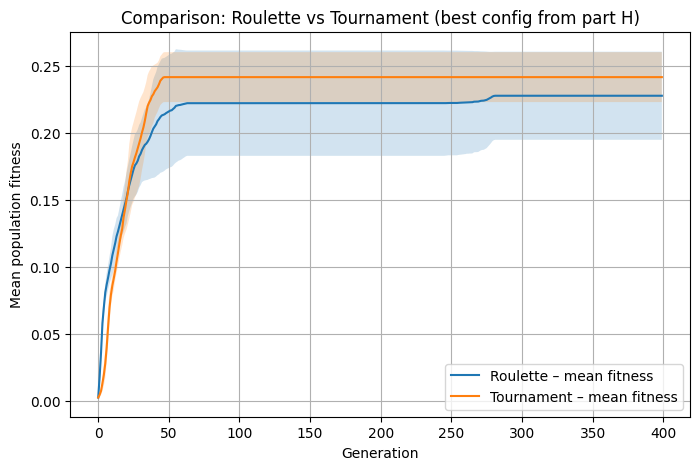

In [34]:
num_runs_compare = 6

# ----- حالت A: انتخاب چرخ‌گردونه‌ای
all_mean_roulette = []
for r in range(num_runs_compare):
    res = run_ea_grouping(
        n=best_n, k=best_k,
        pop_size=best_pop,
        max_generations=best_gen,
        Pc=best_Pc, Pm=best_Pm,
        selection_type="roulette",
        random_seed=r
    )
    all_mean_roulette.append(res["mean_history"])

all_mean_roulette = np.array(all_mean_roulette)
mean_r = np.mean(all_mean_roulette, axis=0)
std_r  = np.std(all_mean_roulette, axis=0)

# ----- حالت B: انتخاب رقابت دودویی با جایگزینی
all_mean_tourn = []
for r in range(num_runs_compare):
    res = run_ea_grouping(
        n=best_n, k=best_k,
        pop_size=best_pop,
        max_generations=best_gen,
        Pc=best_Pc, Pm=best_Pm,
        selection_type="tournament",
        tournament_size=2,
        random_seed=r
    )
    all_mean_tourn.append(res["mean_history"])

all_mean_tourn = np.array(all_mean_tourn)
mean_t = np.mean(all_mean_tourn, axis=0)
std_t  = np.std(all_mean_tourn, axis=0)

# ----- رسم نمودار مقایسه‌ای
gens = np.arange(best_gen)

plt.figure(figsize=(8,5))
plt.plot(gens, mean_r, label="Roulette – mean fitness")
plt.fill_between(gens, mean_r-std_r, mean_r+std_r, alpha=0.2)

plt.plot(gens, mean_t, label="Tournament – mean fitness")
plt.fill_between(gens, mean_t-std_t, mean_t+std_t, alpha=0.2)

plt.xlabel("Generation")
plt.ylabel("Mean population fitness")
plt.title("Comparison: Roulette vs Tournament (best config from part H)")
plt.legend()
plt.grid(True)
plt.show()
